In [1]:
import torch
from torchvision import datasets,transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


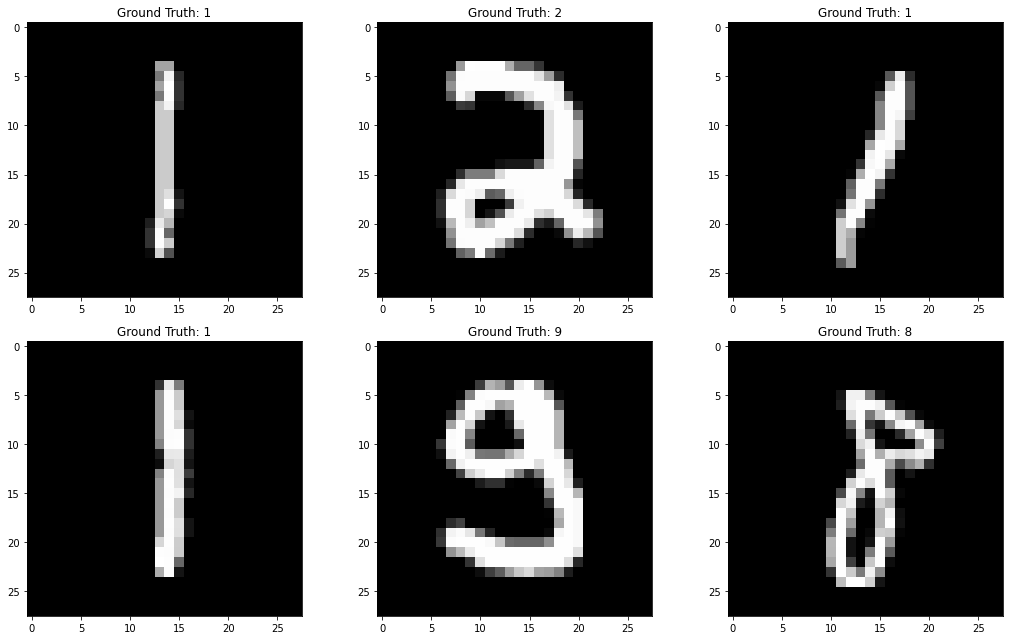

In [11]:
examples = enumerate(train_loader)

batch_idx, (example_data, example_targets) = next(examples)  


fig = plt.figure(figsize=(15, 9))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [3]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x
class MLPModel(nn.Module):
    def __init__(self,in_dim,out_dim,hid_dim):
        super(MLPModel,self).__init__()
        self.linear1 = nn.Linear(in_features = in_dim,out_features = hid_dim)
        self.linear2 = nn.Linear(in_features = hid_dim,out_features = out_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [8]:
cls_loss = nn.CrossEntropyLoss()

In [4]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
in_dim = 784
hid_dim = 200
out_dim = 10
model = MLPModel(in_dim,out_dim,hid_dim)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of 159010 parameters


In [7]:
lr = 0.005
optimizer = optim.Adam(model.parameters(),lr = lr)
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

In [9]:
epoch = 30
for i in range(epoch):
    train_loss = 0
    model.train()
    for input_X,true_y in train_loader:
        optimizer.zero_grad()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1,784)
        pred_y = model(input_X)
        
        loss = cls_loss(pred_y.squeeze(),true_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().numpy()
    train_loss = train_loss/len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    val_loss = 0
    model.eval()
    
    with torch.no_grad():
        for input_X,true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1,784)
            pred_y = model(input_X)
            loss = cls_loss(pred_y.squeeze(),true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss/len(val_loader)
        list_val_loss.append(val_loss)
    correct = 0
    model.eval()
    with torch.no_grad():
        for input_X,true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1,784)
            pred_y = model(input_X).max(1,keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()
        acc = correct.numpy() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Epoch: 0, Train Loss: 0.23175383657407578, Val Loss: 0.13881760479623004, Test Acc: 96.21%
Epoch: 1, Train Loss: 0.10806684182656695, Val Loss: 0.12253052467786812, Test Acc: 96.49%
Epoch: 2, Train Loss: 0.09377942323598944, Val Loss: 0.11337885760431048, Test Acc: 96.87%
Epoch: 3, Train Loss: 0.07607394687669433, Val Loss: 0.12190098288362916, Test Acc: 96.97%
Epoch: 4, Train Loss: 0.07408854604536153, Val Loss: 0.13462765336838328, Test Acc: 96.95%
Epoch: 5, Train Loss: 0.07193792657569394, Val Loss: 0.14590674753100435, Test Acc: 96.64%
Epoch: 6, Train Loss: 0.060034337962675086, Val Loss: 0.16496177373418608, Test Acc: 96.53%
Epoch: 7, Train Loss: 0.05107398258160104, Val Loss: 0.1661988230115628, Test Acc: 97.1%
Epoch: 8, Train Loss: 0.05256992599854241, Val Loss: 0.20609327294875548, Test Acc: 96.65%
Epoch: 9, Train Loss: 0.06526129272707758, Val Loss: 0.20275873641449962, Test Acc: 96.89999999999999%
Epoch: 10, Train Loss: 0.04602777358444343, Val Loss: 0.2001395723546702, Test 

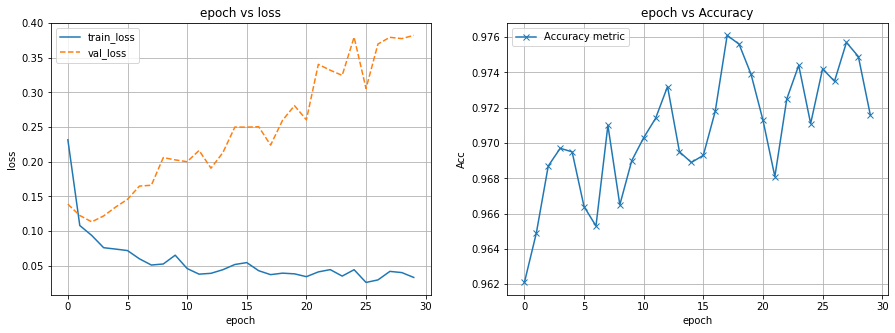

In [10]:

fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()